In [1]:
# First let's import the packages we will use in this project
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
# import matplotlib.mlab as mlab
import matplotlib
# Set the plotting style to 'ggplot' for a clean, professional look with grid background
plt.style.use('ggplot')
from matplotlib.pyplot import figure

# Enable inline plotting so that plots appear directly in the notebook output
%matplotlib inline
# Set the default figure size to 12 inches wide by 8 inches tall for all plots
matplotlib.rcParams['figure.figsize'] = (12,8)

# Disable the SettingWithCopyWarning to avoid false positive warnings when modifying DataFrames
pd.options.mode.chained_assignment = None
# Configure pandas to display all rows in DataFrame outputs by default
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv("who_alcohol.csv")
df.head(10)

,country,iso3,year,sex,alcohol_liters_per_capita,lower_ci,upper_ci,ci_width,IndicatorCode
0,Italy,ITA,2003,Both sexes,9.622988,7.965011,11.388622,3.423611,SA_0000001688
1,"Tanzania, United Republic of",TZA,2006,Both sexes,6.337646,4.767623,8.109324,3.341701,SA_0000001688
2,Cyprus,CYP,2017,Both sexes,6.117152,4.627244,7.798063,3.170819,SA_0000001688
3,Sierra Leone,SLE,2019,Both sexes,0.253228,0.100851,0.567434,0.466583,SA_0000001688
4,Philippines,PHL,2017,Both sexes,6.023875,4.681733,7.536645,2.854912,SA_0000001688
5,Qatar,QAT,2007,Both sexes,1.172084,0.612613,1.854674,1.242061,SA_0000001688
6,Pakistan,PAK,2018,Both sexes,0.104081,0.036438,0.340114,0.303676,SA_0000001688
7,Andorra,AND,2005,Both sexes,13.008124,11.013494,14.829454,3.815960,SA_0000001688
8,Slovenia,SVN,2000,Both sexes,12.477747,10.599043,14.375460,3.776417,SA_0000001688
9,Maldives,MDV,2009,Both sexes,1.963434,0.535407,3.335924,2.800517,SA_0000001688


As we can see, every country has one row for each year between 2000 and 2022 inclusive. 

Let's check for any missing values

In [3]:
# Calculate % of missing values per column. np.mean() on boolean Series (True=1, False=0) gives proportion of True values. Sums number of True (1) and divides by total count

for col in df.columns:
    pct = np.mean(df[col].isnull())
    print(f"{pct * 100}%")


0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%


There are no missing values within the data. 

Let's convert alcohol_liters_per_capita into a more readable and easily understood form.

Let's convert it to units_per_capita_week (UK Units = 10ml Pure alcohol)
Let's also add a percentage of the UK low-risk guideline consumed per week (14 units)

In [4]:
df["units_per_capita_week"] = round(df["alcohol_liters_per_capita"] * 100 / 52, ndigits=1)
df["perc_uk_guideline"] = round(df["units_per_capita_week"] / 14 * 100, ndigits=1)
df.sort_values(by="units_per_capita_week", ascending=False).head()

,country,iso3,year,sex,alcohol_liters_per_capita,lower_ci,upper_ci,ci_width,IndicatorCode,units_per_capita_week,perc_uk_guideline
1027,Romania,ROU,2002,Both sexes,19.497715,16.902455,22.251088,5.348633,SA_0000001688,37.5,267.9
3019,Romania,ROU,2003,Both sexes,19.389771,16.643855,22.116943,5.473088,SA_0000001688,37.3,266.4
803,Romania,ROU,2000,Both sexes,18.993118,16.298520,21.785253,5.486733,SA_0000001688,36.5,260.7
1856,Romania,ROU,2001,Both sexes,18.993118,16.298520,21.785253,5.486733,SA_0000001688,36.5,260.7
1768,Romania,ROU,2004,Both sexes,18.639676,15.787315,21.476058,5.688743,SA_0000001688,35.8,255.7


Let's begin analysing.

### Question 1: Are global alcohol consumption levels trending upward or downward overall?

In [5]:
#finds average consumption per person per year
yearly = df.groupby("year")["alcohol_liters_per_capita"].aggregate('mean')
#convert year index into an explicit column
yearly = yearly.reset_index()


In [6]:
#find global percentage change
g_cons = yearly["alcohol_liters_per_capita"].to_numpy()

#percent change globally between 2000 and 2022
global_change = float(round((g_cons[-1] - g_cons[0]) / g_cons[0] * 100, 1))
global_change

-3.0

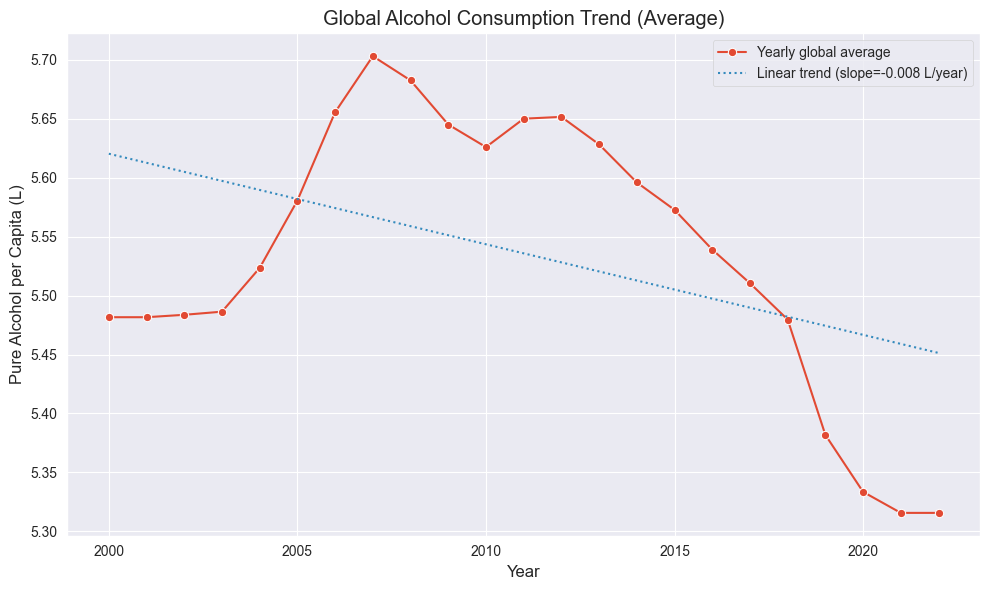

In [7]:
x = yearly["year"]
y = yearly["alcohol_liters_per_capita"]


#np.polyfit() finds best-fitting polynomial curve through data points: y ≈ m*x + c
#degree=1 means "a straight line"
m, c = np.polyfit(x, y, 1)

# This creates the function y = m*x + c
f = np.poly1d([m, c]) #takes a list of coefficients in descending order of polynomial degree
y_best_fit = f(x) # computes y values for all x values


sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

# Plot the actual yearly global averages as a line chart
sns.lineplot(
    data=yearly,
    x=x,
    y=y,
    marker="o", # show dots at each year
    label="Yearly global average"
)

# Overlay the regression line
plt.plot(
    x,
    y_best_fit,
    linestyle=":",
    label=f"Linear trend (slope={m:.3f} L/year)"
)

# Add titles and axis labels so the plot is self-explanatory (portfolio essential)
plt.title("Global Alcohol Consumption Trend (Average)")
plt.xlabel("Year")
plt.ylabel("Pure Alcohol per Capita (L)")
plt.legend()
plt.tight_layout()


Global alcohol consumption levels have been decreasing since 2012 worldwide, -3% between 2000 and 2022 

This is shown by the consistent downwards-sloping trend line in the yearly global average.

The flattening near the end of the graph suggests that global per-capita alcohol consumption has stabilised in the past 3 years.

This suggests that in the long-term, there would limited benefit in relying on global increases in alcohol consumption, emphasising the importance of targeting specific countries that show stronger and more reliable long-term trends.  




### Question 2: Which countries have experienced the largest increases or decreases in alcohol consumption since 2000?


In [8]:
base_2000s = df[df["year"] == 2000]
base_2000s.rename(columns={"alcohol_liters_per_capita":"base_consumption"}, inplace=True)
#join the base 2000s with the original dataframe so that every row now stores what it had in 2000
mdf_2000 = df.merge(right=base_2000s, on="country", how="left")
mdf_2000["per_change"] = round((mdf_2000["alcohol_liters_per_capita"] - mdf_2000["base_consumption"]) / mdf_2000["base_consumption"] * 100)

#remove any country where the starting and ending consumption is less than 1. Removes most widely religious countries where alcohol isn't really consumed at all
mdf_2000 = mdf_2000[(mdf_2000["base_consumption"] >= 1) & (mdf_2000["alcohol_liters_per_capita"] >= 1)]

#decides top x to show 
x_biggest_changes = 3


In [9]:
biggest_increases = (
    mdf_2000
    [mdf_2000["year_x"] == 2022]
    .sort_values(by="per_change", ascending=False)
    .head(x_biggest_changes)
    .reset_index()
    [["country", "base_consumption", "alcohol_liters_per_capita", "per_change"]]

 )
biggest_increases

,country,base_consumption,alcohol_liters_per_capita,per_change
0,Mongolia,2.760842,7.735525,180.0
1,Viet Nam,4.046239,10.715408,165.0
2,Congo,2.718459,6.351449,134.0


In [10]:
biggest_decreases = (
    mdf_2000
    [mdf_2000["year_x"] == 2022]
    .sort_values(by="per_change", ascending=True)
    .reset_index()
    .head(x_biggest_changes)
    [["country", "base_consumption", "alcohol_liters_per_capita", "per_change"]]
 )

biggest_decreases

,country,base_consumption,alcohol_liters_per_capita,per_change
0,"Venezuela, Bolivarian Republic of",8.240533,2.339490,-72.0
1,Burkina Faso,17.475384,7.457268,-57.0
2,Bahrain,2.725937,1.660289,-39.0


Many countries will not be considered in order to make this analysis meaningful.
For instance:
* Yemen ranked first in largest increase. Alcohol is largely illegal in Yemen since over 99% of Yemen's population is Muslim
* 91-97% of Sudan is Sunni Muslim
* 97-99% of Libya is Muslim

In [11]:
#Plotting
#filter mdf_2000 to only contain the countries within biggest_increses and biggest_decreases

inc_x = mdf_2000[mdf_2000["country"].isin(biggest_increases["country"])]
inc_x.sort_values(by=["country", "year_x"], inplace=True)

dec_x = mdf_2000[mdf_2000["country"].isin(biggest_decreases["country"])]
dec_x.sort_values(by=["country", "year_x"], inplace=True)
dec_x.head(5)

,country,iso3_x,year_x,sex_x,alcohol_liters_per_capita,lower_ci_x,upper_ci_x,ci_width_x,IndicatorCode_x,units_per_capita_week_x,...,year_y,sex_y,base_consumption,lower_ci_y,upper_ci_y,ci_width_y,IndicatorCode_y,units_per_capita_week_y,perc_uk_guideline_y,per_change
832,Bahrain,BHR,2000,Both sexes,2.725937,1.761890,3.720094,1.958204,SA_0000001688,5.2,...,2000,Both sexes,2.725937,1.76189,3.720094,1.958204,SA_0000001688,5.2,37.1,0.0
2363,Bahrain,BHR,2001,Both sexes,2.725937,1.761890,3.720094,1.958204,SA_0000001688,5.2,...,2000,Both sexes,2.725937,1.76189,3.720094,1.958204,SA_0000001688,5.2,37.1,0.0
636,Bahrain,BHR,2002,Both sexes,2.597726,1.713092,3.537848,1.824757,SA_0000001688,5.0,...,2000,Both sexes,2.725937,1.76189,3.720094,1.958204,SA_0000001688,5.2,37.1,-5.0
2235,Bahrain,BHR,2003,Both sexes,2.485934,1.669698,3.452146,1.782448,SA_0000001688,4.8,...,2000,Both sexes,2.725937,1.76189,3.720094,1.958204,SA_0000001688,5.2,37.1,-9.0
989,Bahrain,BHR,2004,Both sexes,2.323123,1.468591,3.246961,1.778370,SA_0000001688,4.5,...,2000,Both sexes,2.725937,1.76189,3.720094,1.958204,SA_0000001688,5.2,37.1,-15.0


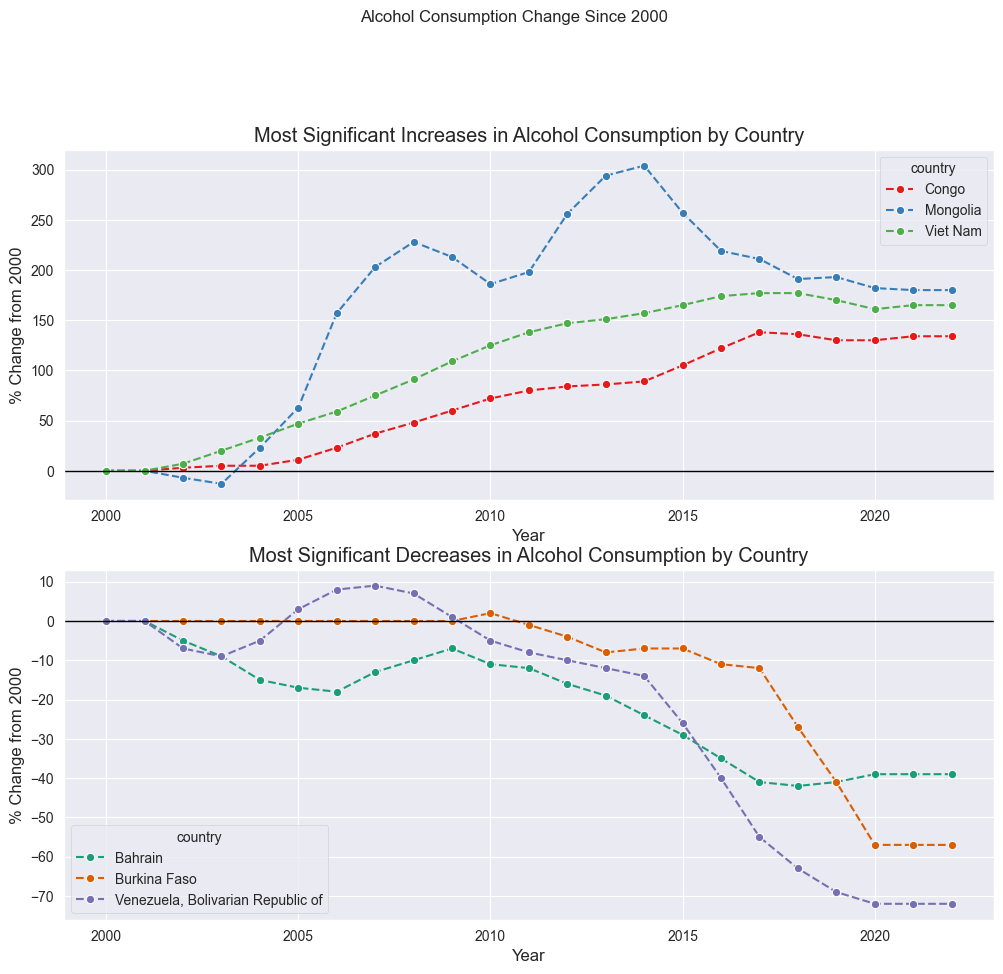

In [12]:
sns.set_style("darkgrid")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
sns.lineplot(
    data=inc_x,
    y="per_change",
    x="year_x",
    hue="country",
    ax=axes[0],
    palette="Set1",
    linestyle="--",
    marker="o" # show dots at each year

)

sns.lineplot(
    data=dec_x,
    y="per_change",
    x="year_x",
    hue="country",
    ax=axes[1],
    palette="Dark2",
    linestyle="--",#
    marker="o" # show dots at each year
)


axes[0].axhline(0, color="black", linewidth=1)
axes[1].axhline(0, color="black", linewidth=1)

axes[0].set_title("Most Significant Increases in Alcohol Consumption by Country")
axes[1].set_title("Most Significant Decreases in Alcohol Consumption by Country")

fig.suptitle("Alcohol Consumption Change Since 2000", y=1.02)



biggest_labels = ["Year", "% Change from 2000"]
axes[0].set_xlabel(biggest_labels[0])
axes[0].set_ylabel(biggest_labels[1])
axes[1].set_xlabel(biggest_labels[0])
axes[1].set_ylabel(biggest_labels[1])

#optional legend styling
    # for ax in axes:
    #     ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
    # Adjust subplot spacing within the figure:
    # rect=(left, bottom, right, top) are fractions of the figure size (0 to 1).
    # Here we shrink the usable plotting area to 82% width (right=0.82) to leave space for the legends.
    # fig.tight_layout(rect=(0, 1, 1, 1))
plt.show()


In [13]:
biggest_increases

,country,base_consumption,alcohol_liters_per_capita,per_change
0,Mongolia,2.760842,7.735525,180.0
1,Viet Nam,4.046239,10.715408,165.0
2,Congo,2.718459,6.351449,134.0


In [14]:
biggest_decreases

,country,base_consumption,alcohol_liters_per_capita,per_change
0,"Venezuela, Bolivarian Republic of",8.240533,2.339490,-72.0
1,Burkina Faso,17.475384,7.457268,-57.0
2,Bahrain,2.725937,1.660289,-39.0


answer: Mongolia, Vietnam, and Congo have had the biggest increase in alcohol consumption since 2000, with Mongolia having the largest.

evidence: This is shown by the blue line consistently being above the green and red line every year since 2005,.

implication: This implies that there has been a boom in alcohol consumption within Mongolia over the past 10-20 years, and it's continuing to stay popular, despite the global decrease. However, Vietnam has had a larger objective increase in alcohol consumption, compared to Mongolia, and shows simliar, stable growth.

actionable insight:  This suggests both Mongolia and Vietnam should be considered for further analysis and possible rollout

Better:

Answer: 
Mongolia, Vietnam, and Congo show the largest increases in alcohol consumption since 2000, with Mongolia exhibiting the strongest sustained upward trend over time.

Evidence: 
This is reflected in consistently higher per-capita consumption levels in Mongolia relative to the other high-growth countries across most years since the mid-2000s, alongside a clear long-term upward trajectory.

Implication: 
These patterns indicate that alcohol consumption has grown substantially in these markets despite the overall global decline, suggesting country-specific drivers of demand rather than global trends alone.

Actionable insight: 
Mongolia and Vietnam, in particular, warrant further market-level analysis as potential expansion targets due to their sustained and relatively stable growth in alcohol consumption over the past two decades.


improvements:
* doesn't talk about chart colours which only make sense to me.
* doesn't claim anything above what the data alone proves (boom / continuing to stay popular is overstating what the data shows)
* Mongolia has the biggest increase, but Vietnam has a larger objective increase. this is confusing without clarification
  

### How consistent is alcohol consumption within countries over time?


#### ask
what decision does this support? whether or not a country will reliably consume the enough alcohol in order for us to choose to sell in that country, such that every year we can be confident that our product will sell enough 

stakeholder - person deciding where our product is sold

visualisation - plot country by its standard deviation



In [58]:
vol = (
    df
    .groupby("country")["alcohol_liters_per_capita"]
    .std()
    .reset_index()
    .rename(columns={"alcohol_liters_per_capita": "std"})
    .sort_values("std", ascending=False)
    .reset_index(drop=True)
)
vol.head(10)

,country,std
0,Burkina Faso,3.559911
1,Mongolia,2.730455
2,Viet Nam,2.612829
3,"Venezuela, Bolivarian Republic of",2.427491
4,Cambodia,1.870162
5,Russian Federation,1.747416
6,Namibia,1.636941
7,China,1.511431
8,Angola,1.472944
9,Ukraine,1.451018


C:\Users\huang_pc\AppData\Local\Temp\ipykernel_15716\2882822843.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


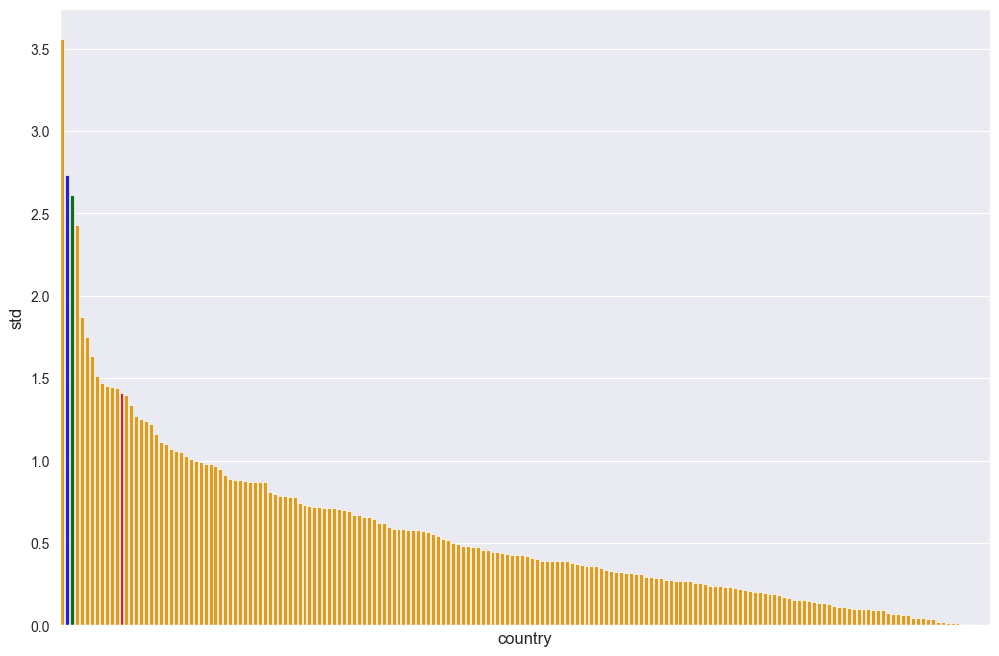

In [ ]:
#highlight countries with largest increase in consumption from before

top_inc_dict = {
    "Viet Nam": "green",
    "Mongolia": "blue",
    "Congo": "red"
    
}

pal_top_inc = {
    c: (top_inc_dict[c] if c in top_inc_dict else "orange") for c in vol["country"]
    }




sns.barplot(
    data=vol,
    x="country",
    y="std",
    palette=pal_top_inc
).tick_params(axis="x", labelbottom=False)